# InfoGAN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.autograd as autograd
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torchvision.utils import save_image
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
#Visualization Tool requires "pip install visdom" (https://github.com/facebookresearch/visdom)
# from visdom_utils import VisFunc
# vf = VisFunc(enval='infoGAN') # Visdom

## MNIST Dataset

In [3]:
batch_size = 100
dataset = dset.MNIST('./dataset', transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

## Define Model

In [4]:
# Feather Extractor
class FrontEnd(nn.Module):
    def __init__(self):
        super(FrontEnd, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(1,64,4,2,1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(64,128,4,2,1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 1024,7,bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
        )

    def forward(self,x):
        output = self.main(x)
        return output

In [5]:
# Discriminator
class Dmodel(nn.Module):
    def __init__(self):
        super(Dmodel, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1024,1,1),
            nn.Sigmoid()
        )

    def forward(self,x):
        output=self.main(x).view(-1,1)
        return output

In [6]:
# Classifier Q
class Qmodel(nn.Module):
    def __init__(self):
        super(Qmodel,self).__init__()

        self.conv = nn.Conv2d(1024,128,1,bias=False)
        self.bn = nn.BatchNorm2d(128)
        self.lReLU = nn.LeakyReLU(0.1, inplace=True)
        self.conv_disc = nn.Conv2d(128,10,1)
        self.conv_mu = nn.Conv2d(128,2,1)
        self.conv_var = nn.Conv2d(128,2,1)

    def forward(self,x):
        y = self.conv(x)
        disc_logits = self.conv_disc(y).squeeze()
        mu = self.conv_mu(y).squeeze()
        var = self.conv_var(y).squeeze().exp()
        return disc_logits, mu, var

In [7]:
# Generator
class Gmodel(nn.Module):
    def __init__(self):
        super(Gmodel, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(74, 1024,1,1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 128,7,1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,1,4,2,1,bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.main(x)
        return output


In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    
# Models
FE=FrontEnd()
D=Dmodel()
Q=Qmodel()
G=Gmodel()

for i in [FE, D, Q, G]:
    i.cuda()
    i.apply(weights_init)

## Defin Losses & Optimizer

![log_gaussian](https://user-images.githubusercontent.com/613623/30778123-7328abc0-a0cd-11e7-8998-7e4ef07cc25f.png)
https://user-images.githubusercontent.com/613623/30778123-7328abc0-a0cd-11e7-8998-7e4ef07cc25f.png

In [9]:
# Define Losses
class log_gaussian:
    def __call__(self, x, mu, var):
        logli = -0.5*(var.mul(2*np.pi)+1e-6).log() - (x-mu).pow(2).div(var.mul(2.0)+1e-6)
        return logli.sum(1).mean().mul(-1)

criterionD = nn.BCELoss()
criterionQ_dis = nn.CrossEntropyLoss()
criterionQ_con = log_gaussian()

In [10]:
# Optimizers
optimD = optim.Adam([{'params':FE.parameters()},
                     {'params':D.parameters()}],
                    lr=0.0002, betas=(0.5, 0.99))

optimG = optim.Adam([{'params':G.parameters()},
                     {'params':Q.parameters()}],
                    lr=0.001, betas=(0.5, 0.99))

## Define Inputs Codes

In [11]:
# fixed random variables for test
c0 = torch.linspace(-1,1,10).view(-1,1).repeat(10,0)
c1 = torch.stack((c0, torch.zeros(1).expand_as(c0)),1).cuda()
c2 = torch.stack((torch.zeros(1).expand_as(c0), c0),1).cuda()
one_hot = torch.eye(10).repeat(1,1,10).view(batch_size,10).cuda()
fix_noise = torch.Tensor(batch_size, 62).uniform_(-1, 1).cuda()

# random noises sampling function
def _noise_sample(dis_c, con_c, noise, bs):
    idx = np.random.randint(10, size=bs)
    c = np.zeros((bs, 10))
    c[range(bs),idx] = 1.0
    dis_c.data.copy_(torch.Tensor(c))
    con_c.data.uniform_(-1.0, 1.0)
    noise.data.uniform_(-1.0, 1.0)
    z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)
    return z, idx

## Training

Epoch:0, Iter:0, Dloss: 1.440699577331543, Gloss: 3.1755173206329346, Preal: 0.5643081068992615, Pfake: 0.5214758515357971


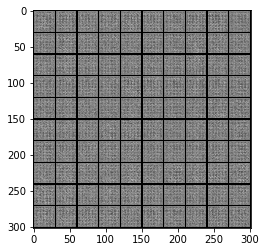

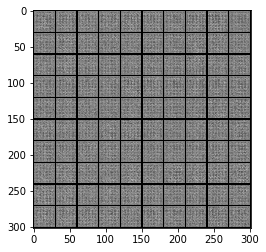

Epoch:0, Iter:200, Dloss: 0.8290097713470459, Gloss: 1.2475290298461914, Preal: 0.6871532201766968, Pfake: 0.30070996284484863


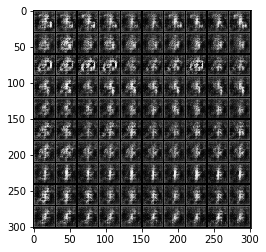

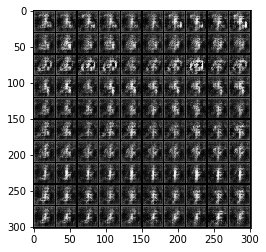

Epoch:0, Iter:400, Dloss: 1.130944013595581, Gloss: 1.0008376836776733, Preal: 0.5694864988327026, Pfake: 0.379522442817688


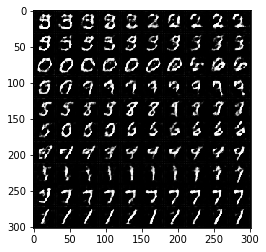

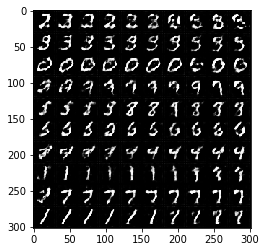

Epoch:1, Iter:0, Dloss: 1.192613959312439, Gloss: 0.9503867626190186, Preal: 0.5668295621871948, Pfake: 0.399265855550766


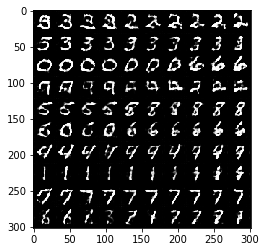

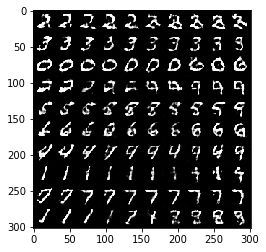

Epoch:1, Iter:200, Dloss: 1.1668918132781982, Gloss: 0.9466885924339294, Preal: 0.559329092502594, Pfake: 0.3777126669883728


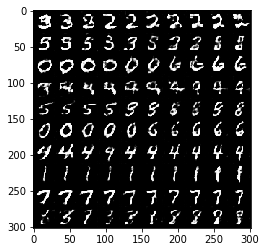

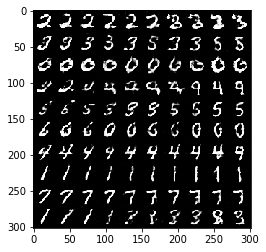

Epoch:1, Iter:400, Dloss: 1.1185797452926636, Gloss: 0.9455455541610718, Preal: 0.5913896560668945, Pfake: 0.38021138310432434


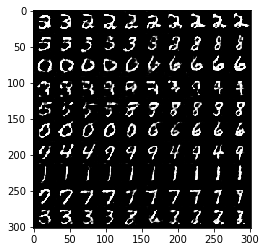

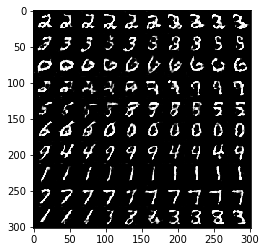

Epoch:2, Iter:0, Dloss: 1.1790547370910645, Gloss: 0.9478936195373535, Preal: 0.5681582093238831, Pfake: 0.39184924960136414


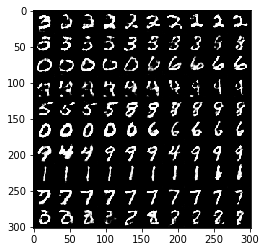

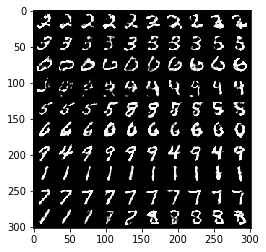

Epoch:2, Iter:200, Dloss: 1.198262333869934, Gloss: 0.9888976812362671, Preal: 0.5733132362365723, Pfake: 0.3915986120700836


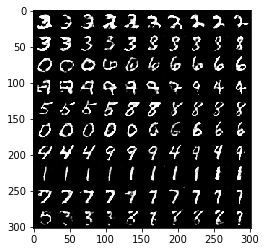

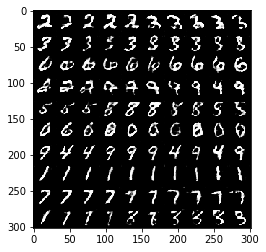

Epoch:2, Iter:400, Dloss: 1.157468557357788, Gloss: 0.9458397626876831, Preal: 0.5867165923118591, Pfake: 0.3751709759235382


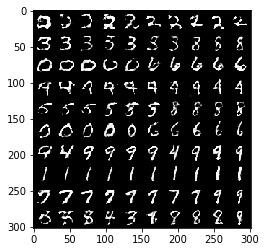

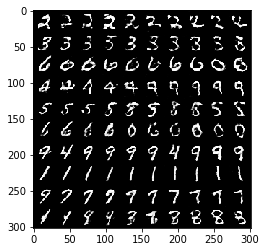

Epoch:3, Iter:0, Dloss: 1.2478711605072021, Gloss: 0.8751834034919739, Preal: 0.5556743144989014, Pfake: 0.4065396785736084


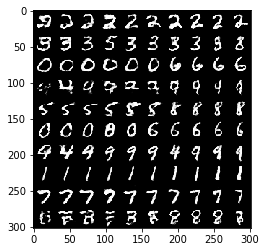

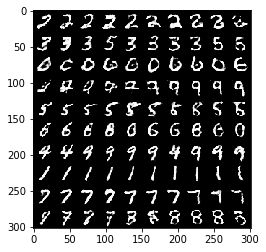

Epoch:3, Iter:200, Dloss: 1.1087796688079834, Gloss: 1.0533947944641113, Preal: 0.5735929608345032, Pfake: 0.3669815957546234


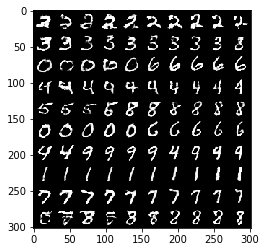

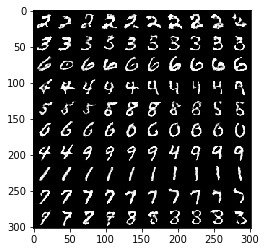

Epoch:3, Iter:400, Dloss: 1.1513583660125732, Gloss: 0.9776834845542908, Preal: 0.5551347136497498, Pfake: 0.36730411648750305


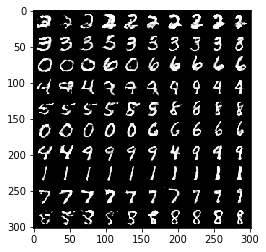

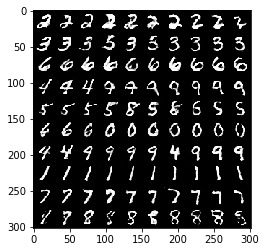

Epoch:4, Iter:0, Dloss: 1.1622123718261719, Gloss: 0.9130094647407532, Preal: 0.5893028378486633, Pfake: 0.38395386934280396


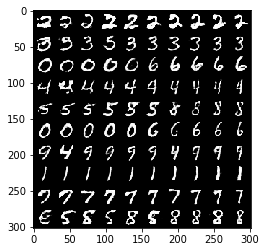

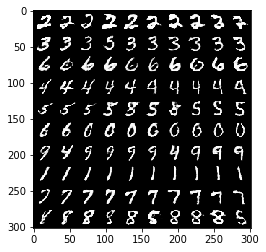

Epoch:4, Iter:200, Dloss: 1.1820616722106934, Gloss: 0.9938083291053772, Preal: 0.555184006690979, Pfake: 0.37589767575263977


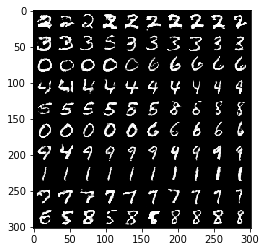

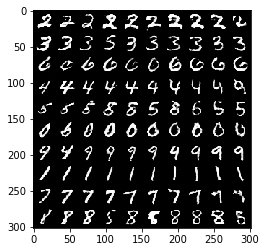

Epoch:4, Iter:400, Dloss: 1.1713440418243408, Gloss: 0.9269705414772034, Preal: 0.5805357694625854, Pfake: 0.398997962474823


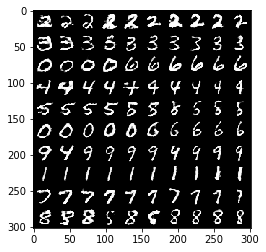

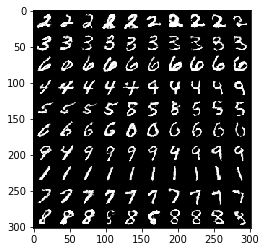

Epoch:5, Iter:0, Dloss: 1.2757267951965332, Gloss: 0.9400074481964111, Preal: 0.558879017829895, Pfake: 0.40063706040382385


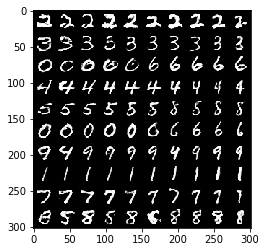

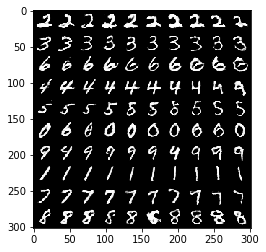

Epoch:5, Iter:200, Dloss: 1.2647019624710083, Gloss: 0.8890984058380127, Preal: 0.5534305572509766, Pfake: 0.3960363268852234


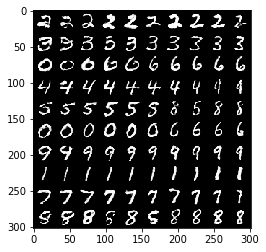

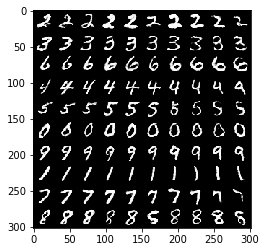

Epoch:5, Iter:400, Dloss: 1.2050271034240723, Gloss: 0.877480149269104, Preal: 0.5602731108665466, Pfake: 0.3899953365325928


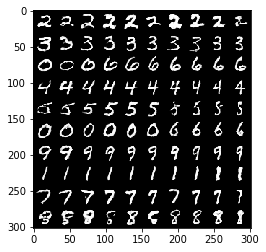

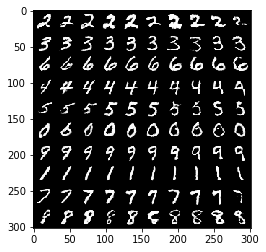

Epoch:6, Iter:0, Dloss: 1.1807870864868164, Gloss: 0.9996479749679565, Preal: 0.5714429616928101, Pfake: 0.3832731246948242


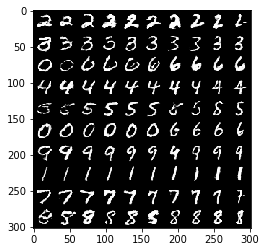

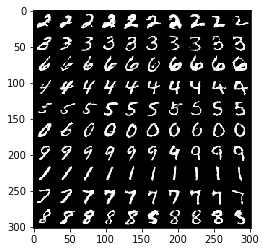

Epoch:6, Iter:200, Dloss: 1.1880285739898682, Gloss: 0.9122405648231506, Preal: 0.5832316279411316, Pfake: 0.38755539059638977


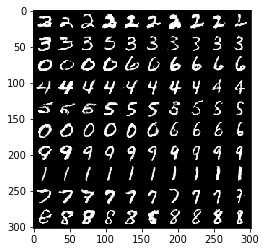

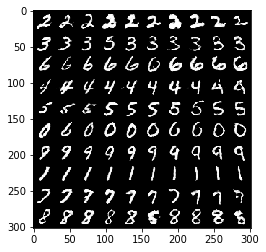

Epoch:6, Iter:400, Dloss: 1.1762595176696777, Gloss: 0.8953178524971008, Preal: 0.5740389227867126, Pfake: 0.3821229040622711


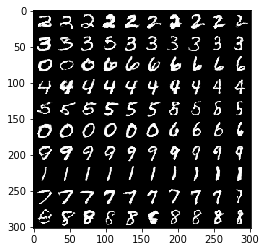

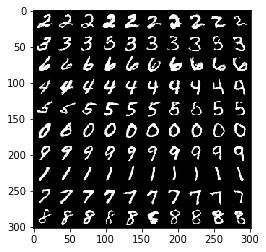

Epoch:7, Iter:0, Dloss: 1.1908667087554932, Gloss: 0.9677220582962036, Preal: 0.5847957730293274, Pfake: 0.37685662508010864


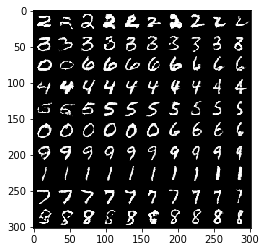

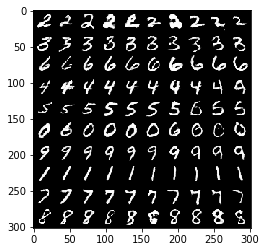

Epoch:7, Iter:200, Dloss: 1.2554291486740112, Gloss: 0.9132112264633179, Preal: 0.5628873705863953, Pfake: 0.4028486907482147


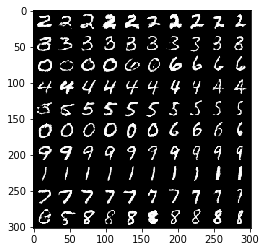

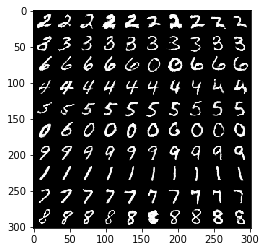

Epoch:7, Iter:400, Dloss: 1.164153814315796, Gloss: 1.0052909851074219, Preal: 0.5572206377983093, Pfake: 0.36015498638153076


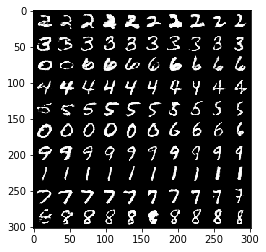

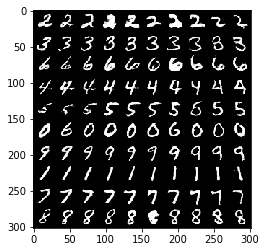

In [12]:
for epoch in range(8):
    for num_iters, batch_data in enumerate(dataloader,0):
        real_labels = torch.ones(batch_size,1).cuda()
        fake_labels = torch.zeros(batch_size,1).cuda()
        
        # Train Discriminator D and Feature Extractor FE
        # real part
        x, _ = batch_data
        real_x = x.cuda()

        fe_out1 = FE(real_x)
        probs_real = D(fe_out1)
        loss_real = criterionD(probs_real, real_labels)

        # fake part
        dis_c = torch.FloatTensor(batch_size,10).cuda()
        con_c = torch.FloatTensor(batch_size,2).cuda()
        noise = torch.FloatTensor(batch_size,62).cuda()
        z, idx = _noise_sample(dis_c,con_c,noise,batch_size)

        fake_x = G(z)
        fe_out2 = FE(fake_x.detach())
        probs_fake = D(fe_out2)
        loss_fake = criterionD(probs_fake, fake_labels)

        D_loss = loss_real + loss_fake
        
        optimD.zero_grad()
        D_loss.backward()
        optimD.step()

        # Train Generator G and Clasifier Q (Lower bound of InfoMax Term)        
        fe_out = FE(fake_x)
        probs_fake = D(fe_out)
        G_loss = criterionD(probs_fake, real_labels)

        q_logits, q_mu, q_var = Q(fe_out)
        target_class = torch.LongTensor(idx).cuda()
        
        dis_loss = criterionQ_dis(q_logits, target_class)        
        con_loss = criterionQ_con(con_c, q_mu, q_var)*0.1
        
        G_loss_with_InfoMax = G_loss + dis_loss + con_loss
        
        optimG.zero_grad()
        G_loss_with_InfoMax.backward()
        optimG.step()

        if num_iters % 200 == 0:
            print('Epoch:{0}, Iter:{1}, Dloss: {2}, Gloss: {3}, Preal: {4}, Pfake: {5}'.format(
                epoch, num_iters, D_loss.data.cpu().numpy(),
                G_loss_with_InfoMax.data.cpu().numpy(), probs_real.data.mean(), probs_fake.data.mean())
            )

            z = torch.cat([fix_noise, one_hot, c1], 1).view(-1, 74, 1, 1)
            x_save = G(z)
            
            if not os.path.exists('infoGan_out/'):
                os.makedirs('infoGan_out/')
            
            title1 = '(C1)'+str(epoch)+'_'+str(num_iters)
            save_image(x_save.data, 'infoGan_out/'+title1+'.png', nrow=10)
#             vf.imshow_multi(x_save.data.cpu(), nrow=10, title=title1,factor=1)
             
            plt.imshow(make_grid((x_save.data.cpu()), nrow=10).cpu().permute(1,2,0).numpy())
            plt.show()              
            
            z = torch.cat([fix_noise, one_hot, c2], 1).view(-1, 74, 1, 1)
            x_save = G(z)
            
            title2 = '(C2)'+str(epoch)+'_'+str(num_iters)
            save_image(x_save.data, 'infoGan_out/'+title2+'.png', nrow=10)
#             vf.imshow_multi(x_save.data.cpu(), nrow=10, title=title2,factor=1)
            
            plt.imshow(make_grid((x_save.data.cpu()), nrow=10).cpu().permute(1,2,0).numpy())
            plt.show()  
    